In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

In [ ]:
#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/SourceCode /content

from SourceCode.mainbody import mainbody
from SourceCode.getboundary import getboundary

In [ ]:
import csv
import ntpath
import re
import os
import numpy as np
import pickle
from skimage.io import imread, imsave, imshow

# Copy segmented, labeled images from GCP to local directory

In [ ]:
treatment_path = 'cellmbucket/analysis/controls_paths_03082022_stiff.txt' #@param {type:"string"}

#read treatment locations file
!gsutil cp gs://{treatment_path} ./
treatment_file = ntpath.basename(treatment_path)
treatment_obj = open(treatment_file, "r")
treatment_locs = treatment_obj.readlines()

Copying gs://cellmbucket/analysis/controls_paths_03082022_stiff.txt...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      


In [ ]:
min_track_length = 25 #@param {type:"integer"}

In [ ]:
treatment_locs

['controls\n',
 'cellmbucket/analysis_042221/06032020-JR20-control\n',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5\n',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control\n',
 'cellmbucket/analysis_sam_042821/031521_control_sample3\n',
 'cellmbucket/analysis_sam_042821/031521_control_sample4\n',
 'cellmbucket/analysis_sam_042821/031521_control_sample5\n',
 '\n',
 'cellmbucket/analysis_eliz_05042021/trial1/05042021_ARPC2_KO_sample6\n',
 'cellmbucket/analysis_eliz_05042021/trial3/05112021_ARPC2_KO_sample3\n',
 'cellmbucket/analysis_eliz_05042021/trial4/05202021_ARPC2_KO_sample4\n',
 'cellmbucket/analysis_eliz_05042021/trial5/060622021_ARPC2_KO_sample3\n',
 '\n',
 'cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_sample3\n',
 'cellmbucket/analysis_eliz_05262021/trial2/052822021_Fascin_KO_sample3\n',
 'cellmbucket/analysis_eliz_05262021/trial3/060222021_Fascin_KO_sample3\n',
 '\n',
 'cellmbucket/analysis_eliz_09162021/09162021\n',
 '\n',
 'cellmbu

In [ ]:
#get all files full paths. Some data has the same name but is stored in different folder
file_paths = []
#tracks_shape_file_paths = []
for i in range(1,len(treatment_locs)):
  if len(treatment_locs[i].strip("\n")) > 0: #if line contains data
    file_paths.append(treatment_locs[i].strip("\n"))
    #tracks_shape_file_paths.append(treatment_locs[i].strip("\n")+'_tracks_shape') 

In [ ]:
file_paths

['cellmbucket/analysis_042221/06032020-JR20-control',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control',
 'cellmbucket/analysis_sam_042821/031521_control_sample3',
 'cellmbucket/analysis_sam_042821/031521_control_sample4',
 'cellmbucket/analysis_sam_042821/031521_control_sample5',
 'cellmbucket/analysis_eliz_05042021/trial1/05042021_ARPC2_KO_sample6',
 'cellmbucket/analysis_eliz_05042021/trial3/05112021_ARPC2_KO_sample3',
 'cellmbucket/analysis_eliz_05042021/trial4/05202021_ARPC2_KO_sample4',
 'cellmbucket/analysis_eliz_05042021/trial5/060622021_ARPC2_KO_sample3',
 'cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_sample3',
 'cellmbucket/analysis_eliz_05262021/trial2/052822021_Fascin_KO_sample3',
 'cellmbucket/analysis_eliz_05262021/trial3/060222021_Fascin_KO_sample3',
 'cellmbucket/analysis_eliz_09162021/09162021',
 'cellmbucket/analysis_eliz_062719/controls_2019_062719_sample1',
 'cellmbucket/

In [ ]:
for maskspath in file_paths:
  !gsutil cp gs://{maskspath}_tracks_masks.zip ./
  folder_loc = ntpath.basename(maskspath)
  folderimages = folder_loc + '_tracks_masks'
  !unzip {folderimages}.zip

  !gsutil cp gs://{maskspath}_tracks_shape.pkl ./
  with open('/content/' + folder_loc + '_tracks_shape.pkl', 'rb') as handle:
            tracksshape = pickle.load(handle, encoding='latin1')

  #use tracksshape to save individual tiff files from tiff stacks according to the region they correspond to into a folder labeled by that region
  names_movies=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

  for region in ['stiff', 'gradient1', 'gradient2', 'soft', 'newsteep', 'glass']:
    if os.path.exists('/content/' + region) == False:
      !mkdir {region}
    for i in range(len(tracksshape)):
      if tracksshape[i]['gel-region'].str.contains(region).any():
        if len(tracksshape[i]) >= min_track_length:
          trackid = tracksshape[i]['track_id'].loc[0]
          movieid = int(tracksshape[i]['movie'].loc[0])
          for name in names_movies:
            if '_track' + trackid + '.TIF' in name:
              movie=imread(folderimages+'/'+name)
              name=name.strip('.TIF')
              for i in range(movie.shape[0]):
                imagename = name + '_' + region + '_movie' + str(movieid) + '_t'+str(i+1)+'.TIF'
                imsave(region + '/' + imagename, movie[i])

Output hidden; open in https://colab.research.google.com to view.

##Save images separated by region on GCS

In [ ]:
#@markdown Date of running this analysis and image description (will be included in the zip file name of the separated images by region)
descriptor = 'controls_paths_03082022_stiff' #@param {type:"string"}

In [ ]:
!zip -r {descriptor}_controls_4regions_masksbytrack.zip soft gradient1 gradient2 stiff newsteep

In [ ]:
!gsutil cp /content/{descriptor}_controls_4regions_masksbytrack.zip gs://cellmbucket/analysis

# Make csv file that contains paths to segmented, labeled images in local directory with descriptions for each set

In [ ]:
csv_fields=['set ID', 'condition', 'set location', 'tag', 'note']

In [ ]:
#@markdown Parameters for the csv that indicate where the masks are located

#@markdown Row index number
setID1 = '1' #@param {type:"string"}
#setID2 = '2' #@param {type:"string"}
#setID3 = '3' #@param {type:"string"}
#setID4 = '4' #@param {type:"string"}
#@markdown Description of an image set
condition1 = 'stiff' #@param {type:"string"}
#condition2 = 'soft' #@param {type:"string"}
#condition3 = 'gradient2' #@param {type:"string"}
#condition4 = 'soft' #@param {type:"string"}
#@markdown The path of the folder containing the segmented images
set_location1 = '/content/stiff' #@param {type:"string"}
#set_location2 = '/content/soft' #@param {type:"string"}
#set_location3 = '/content/gradient2' #@param {type:"string"}
#set_location4 = '/content/soft' #@param {type:"string"}
#@markdown String of text where only segmented images in the set location with filenames containing the tag will be analyzed
tag1 = 'track' #@param {type:"string"}
#tag2 = 'track' #@param {type:"string"}
#tag3 = 'track' #@param {type:"string"}
#tag4 = 'track' #@param {type:"string"}
#@markdown Any information about the image sets used only for the user's record. This is not used in the analysis
note1 = 'stiff' #@param {type:"string"}
#note2 = 'all_controls' #@param {type:"string"}
#note3 = 'all_controls' #@param {type:"string"}
#note4 = 'all_controls' #@param {type:"string"}
#@markdown Name of the csv file that is created
csv_name = 'segmented_image_sets_to_build_model_colab' #@param {type:"string"}

In [ ]:
rows=[[setID1,
  condition1,
  set_location1,
  tag1,
  note1]]

In [ ]:
csv_filename = '/content/' + csv_name + '.csv'

In [ ]:
with open(csv_filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
      
    # writing the fields
    csvwriter.writerow(csv_fields)
      
    # writing the data rows
    csvwriter.writerows(rows)

# Specify VAMPIRE model parameters

In [ ]:
entries={}

In [ ]:
fields = (
        'Build Model', 'Image sets to build', 'Number of coordinates', 'Number of principal components', 'Number of shape modes', 'Model output folder',
        'Model name', 'Image sets to apply', 'Model to apply', 'Result output folder')

In [50]:
#@markdown Parameters for VAMPIRE model

#@markdown Build model (True or False)
Build_Model = False #@param {type:"boolean"}
#@markdown Path to csv file to load that contains path to masks
Image_sets_to_build = '/content/segmented_image_sets_to_build_model_colab.csv' #@param {type:"string"}
#@markdown Number of coordinates used to describe cell shape
Number_of_coordinates = '100' #@param {type:"string"}
#@markdown Number of principal components to use for PCA
pcnum = '10' #@param {type:"string"}
#@markdown Number of clusters to form to describe cell shapes
Number_of_shape_modes = '10' #@param {type:"string"}
#@markdown Path to location where output data is saved
Model_output_folder = '/content' #@param {type:"string"}
#@markdown Name of folder where output will be saved (and name of the model pickle file)
Model_name = '100Coords10PC10ShapeModes_1Region_controls' #@param {type:"string"}
#@markdown Apply model

#@markdown Only complete the below entries if you are applying the model

#@markdown Path to csv file to load that contains path to masks
Image_sets_to_apply = '/content/segmented_image_sets_to_build_model_colab.csv' #@param {type:"string"}
#@markdown Path to pickle model file 
Model_to_apply = '/content/100Coords10PC10ShapeModes_1Region_controls/100Coords10PC10ShapeModes_1Region_controls.pickle' #@param {type:"string"}
#@markdown Path to location where outpur data is saved (usually the folder that was created with Build Model)
Result_output_folder = '/content/100Coords10PC10ShapeModes_1Region_controls' #@param {type:"string"}


In [51]:
ents = [Build_Model, Image_sets_to_build, Number_of_coordinates, pcnum, Number_of_shape_modes, Model_output_folder, Model_name, Image_sets_to_apply, Model_to_apply, Result_output_folder]

for count,field in enumerate(fields):
  entries[field] = ents[count]

In [52]:
# Make folders in local directory where figures and model pickle file will be saved 

if Build_Model:
  foldername = Model_output_folder + '/' + Model_name
  !mkdir {foldername}
  newfolder = foldername + '/' + 'Example model figures'
  !mkdir '{newfolder}'
else:
  foldername = Result_output_folder + '/' + 'Result based on ' + ntpath.basename(Result_output_folder)
  !mkdir '{foldername}'

In [53]:
entries

{'Build Model': False,
 'Image sets to apply': '/content/segmented_image_sets_to_build_model_colab.csv',
 'Image sets to build': '/content/segmented_image_sets_to_build_model_colab.csv',
 'Model name': '100Coords10PC10ShapeModes_1Region_controls',
 'Model output folder': '/content',
 'Model to apply': '/content/100Coords10PC10ShapeModes_1Region_controls/100Coords10PC10ShapeModes_1Region_controls.pickle',
 'Number of coordinates': '100',
 'Number of principal components': '10',
 'Number of shape modes': '10',
 'Result output folder': '/content/100Coords10PC10ShapeModes_1Region_controls'}

In [54]:
def Model(entries, buildModel):
    if buildModel:
        csv = entries['Image sets to build']
        clnum = entries['Number of shape modes']
        outpth = entries['Model output folder']  # name
        getboundary(csv, outpth, entries, buildModel)  # create registry csv and boundary stack
        mainbody(buildModel, csv, entries, outpth, clnum)
    else:
        csv = entries['Image sets to apply']
        outpth = entries['Result output folder']
        clnum = None
        getboundary(csv, outpth, entries, buildModel)  # create registry csv and boundary stack
        mainbody(buildModel, csv, entries, outpth, clnum)


def vampire():
    Model(entries, Build_Model)

# Run the VAMPIRE analysis

In [55]:
vampire()

## getboundary.py
registry or boundary already exist
## main.py
## bdreg.py
applying model
available cpu cores :  2
For parallel of bdreg, elapsed time is 223.25664639472961seconds...
## pca_bdreg.py
For PCA bdreg, elapsed time is 0.06168723106384277seconds...
# clusterSM
For cluster, elapsed time is 1.0588085651397705seconds...
## update_csv.py


# Copy files generated from VAMPIRE analysis (csv files of shape features, model pickle file, pickle files of boundary coordinates, and figures) to GCP bucket

In [56]:
#@markdown Where to save VAMPIRE files in GCP bucket
GCP_path = 'cellmbucket/VAMPIRE_analysis/all_controls/stiff' #@param {type:"string"}
#@markdown Name of folder that will contain all generated files from the VAMPIRE analysis in GCP bucket
output_folder = '03122022_trackslongerthan25' #@param {type:"string"}

In [57]:
output_data = Model_output_folder + '/' + Model_name

output_path = GCP_path + '/' + output_folder + '/'

!gsutil cp -r '{output_data}'  gs://{output_path}

Copying file:///content/100Coords10PC10ShapeModes_1Region_controls/stiff_boundary_coordinate_stack.pickle [Content-Type=application/octet-stream]...
Copying file:///content/100Coords10PC10ShapeModes_1Region_controls/VAMPIRE datasheet stiff.csv [Content-Type=text/csv]...
Copying file:///content/100Coords10PC10ShapeModes_1Region_controls/100Coords10PC10ShapeModes_1Region_controls.pickle [Content-Type=application/octet-stream]...
Copying file:///content/100Coords10PC10ShapeModes_1Region_controls/Result based on 100Coords10PC10ShapeModes_1Region_controls/Shape mode distribution_1_stiff.png [Content-Type=image/png]...
\ [4 files][ 45.3 MiB/ 45.3 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///content/100Coords10PC10ShapeMo

## This is just code to copy things from google cloud bucket to here to zip and download locally

In [ ]:
!gsutil cp -r gs://cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_VAMPIRE_analysis/50Coords10ShapeModes_AllRegionsSample4 ./

Copying gs://cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_VAMPIRE_analysis/50Coords10ShapeModes_AllRegionsSample4/50Coords10ShapeModes_AllRegionsSample4.pickle...
Copying gs://cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_VAMPIRE_analysis/50Coords10ShapeModes_AllRegionsSample4/Example model figures/Registered objects.png...
Copying gs://cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_VAMPIRE_analysis/50Coords10ShapeModes_AllRegionsSample4/Example model figures/Shape mode dendrogram.png...
Copying gs://cellmbucket/analysis_eliz_05262021/trial1/052622021_Fascin_KO_VAMPIRE_analysis/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/Shape mode distribution_1_stiff.png...
| [4 files][  1.4 MiB/  1.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m sect

In [ ]:
!zip -r "/content/50Coords10ShapeModes_AllRegionsSample4.zip" "/content/50Coords10ShapeModes_AllRegionsSample4"

  adding: content/50Coords10ShapeModes_AllRegionsSample4/ (stored 0%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/stiff_boundary_coordinate_stack.pickle (deflated 90%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/ (stored 0%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/Shape mode distribution_3_steep2.png (deflated 9%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/Shape mode distribution_2_steep1.png (deflated 8%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/Shape mode distribution_4_soft.png (deflated 9%)
  adding: content/50Coords10ShapeModes_AllRegionsSample4/Result based on 50Coords10ShapeModes_AllRegionsSample4/Shape mode distribution_1_stiff.png (deflated 9%)
  adding: content/50Coords10ShapeModes_AllReg

In [ ]:
from skimage.io import imread, imsave, imshow

In [ ]:
print(np.shape(imread('/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t1.TIF')))

(256, 336)


In [ ]:
imread('/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t1.TIF')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


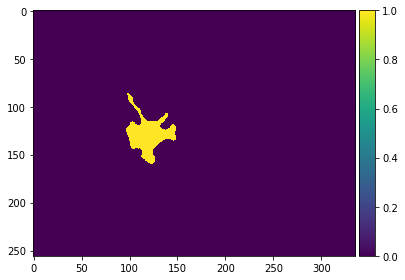

In [ ]:
imshow('/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t1.TIF')

In [ ]:
!cp /content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t1.TIF /content/

In [ ]:
! ls /content/stiff/controls_2019_062819_sample2_track3*

/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t10.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t11.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t12.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t13.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t14.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t15.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t16.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t17.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t18.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t19.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t1.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t20.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t21.TIF
/content/stiff/controls_2019_062819_sample2_track3_stiff_movie3_t